# 

In [1]:
!pip install mauve-text
!pip install transformers
from parameter_tuning import train_model
from generator import Generator
from discriminator import Discriminator
import torch
import torch.optim as optim
import torch.nn as nn
from parse_data import get_data, get_modified_values, get_binary_values, make_data_scalar
import numpy as np
from evaluation import evaluate_model, bin_plot
import random
from data_gen import Datagen

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

 

Using device:  cuda


tensor([[[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000]],

        ...,

        [[0.9849],
         [1.0000]],

        [[1.0000],
         [0.9974]],

        [[1.0000],
         [1.0000]]], device='cuda:0')


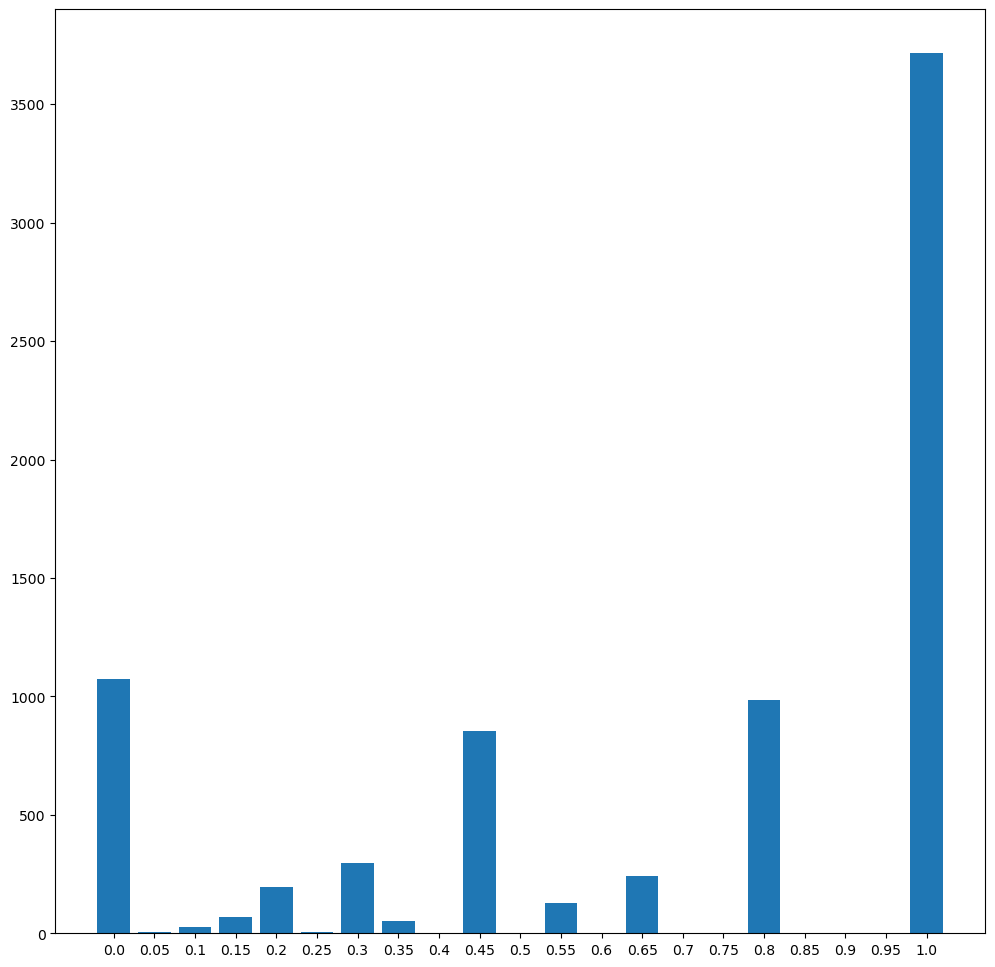

In [2]:
gen = Datagen(device)

x, y = gen.get_true_data(10)



bin_plot(y, 0, 1, None, 0.05)

x_d, y_d = gen.get_generated_data(seq_len=2)
print(x_d)


In [3]:
import random

# Hyperparameters
sequence_length = [2*i for i in range(4,16)] # 2-20 increments of two
hidden_layers = [1,2]*10 # 1 and 2
hidden_1 = [2**i for i in range(5,10)] # 2^4 to 2^9
hidden_2 =[2**i for i in range(5,10)] # 2^2 to 2^5
variance = [0.001, 0.01, 0.005, 0.05]
lr = [0.001, 0.01, 0.1, 0.005] # stop at 0.005
data_probability = [i/5 for i in range(1,6)]
noise_in_model = [True, False]
epochs = 3500
optimizer = [optim.Adam, optim.SGD]
print(hidden_layers)

options = []

for seq_len in sequence_length:
    for layers in hidden_layers:
        for h1 in hidden_1:
            for h2 in hidden_2:
                for l in lr:
                    for v in variance:
                        for p in data_probability:
                            for n in noise_in_model:
                                entry = {}
                                entry["seq_len"] = seq_len
                                entry["layers"] = layers
                                entry["gen"] = h1
                                entry["disc"] = h2
                                entry["l"] = l
                                entry["variance"] = v
                                entry["data_prob"] = p
                                entry["noise_model"] = n
                                options.append(entry)
                
                                         
random.shuffle(options)    



[1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]


In [ ]:
from IPython.display import clear_output

best_model = None
best_history = [""]
best_config = None
best_score = 1
for entry in options:
    x_d, y_d = gen.get_generated_data(entry["seq_len"], entry["variance"], entry["data_prob"])
    x_t, y_t = gen.get_true_data(entry["seq_len"])
    x_val, y_val = gen.get_test_data(entry["seq_len"])
    
    model_g = Generator(input_dim=x_d[0].size()[1],
                        output_dim=y_d[0].size()[0],
                        layers=entry["layers"],
                        g_size=entry["gen"],
                        device=device).to(device)
    print("input dim", x_d[0].size())
    model_d = Discriminator(input_dim=x_d[0].size()[1],
                            output_dim=y_d[0].size()[0],
                            layers=entry["layers"],
                            hidden_size=entry["disc"],
                            device=device).to(device)
    
    
    print("Running model: ", entry, " epochs: ", epochs)

    
    model, history = train_model(model_g=model_g,
                                 model_d=model_d,
                                 x_data=x_d,
                                 y_data=y_d,
                                 batch_size=100,
                                 seq_len=entry["seq_len"],
                                 epochs=epochs,
                                 loss=nn.MSELoss(),
                                 optimizer=optim.Adam,
                                device=device)
    clear_output()
    if history[-1][1] < best_score:
        print("New best model:\nNew loss: ", history[-1], "\nOld loss:", best_history[-1], "\nHistory:" , history[-10:])
        best_model = model
        best_history = history
        best_score = history[-1][1]
        best_config = entry
        evaluate_model(best_model, x_t, y_t,x_val,y_val, entry)
    else:
        evaluate_model(model, x_t, y_t,x_val,y_val, entry)
        print("Old model still stands:\nCurrent loss: ", history[-1], "\nBest loss:", best_history[-1])
                                 

    

input dim torch.Size([26, 1])
Running model:  {'seq_len': 26, 'layers': 1, 'gen': 256, 'disc': 128, 'l': 0.1, 'variance': 0.01, 'data_prob': 0.4, 'noise_model': True}  epochs:  3500
[0, 0.11474552295382279, 87.8751160800457]
[10, 0.11472146271414296, 87.92302782088518]
[20, 0.10482289293883053, 80.17142739892006]
[30, 0.27805768151818616, 213.64410042762756]
[40, 0.15010286363780342, 114.25262275338173]
[50, 0.1380682083396314, 106.1486749202013]
[60, 0.1628083413559214, 125.01149868965149]
[70, 0.19290634795206335, 148.59538599848747]
[80, 0.182119581897016, 139.55276104807854]
[90, 0.16087634258419664, 125.06360764801502]
[100, 0.12062525142266296, 91.70542748272419]
[110, 0.09112199752861463, 69.76300451159477]
[120, 0.14978092476997923, 115.07674326002598]
[130, 0.12613347194135657, 95.44865208864212]
[140, 0.17093501679657644, 130.77953968942165]
[150, 0.14107852637300913, 109.1000238507986]
[160, 0.1623681547514141, 124.24215593934059]
[170, 0.1248753697224759, 96.87994237244129]

#### 